# Job Descriptions: Exploring what combination of factors best predict if a job posting is fradulent 

- **Data Set:** [job descriptions dataset](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction) 

Our goal in this notebook is to explore which columns have the highest correlation with the column `fraudulent`. Moreover, we will investigate if there are unique column values in which these values have a high likelyhood of being attributes of fraudulent jobs. The data set also has lots of text data, and we will be analyzing which words are indicators of a job posting being fraudulent using TF-IDF and a simple logistic regression model. We will also make use of the other attributes by using a K-nearest neighbors model to predict whether a job posting is fake. Overall the mission of this work is to provide a recommendation to executives at a company who are considering creating a branch of the business which uses software to predict fraudulent job postings. We achive this by advising them on what atrributes have the strongest correlation, and share our preliminary results from our models.  


#Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_dir = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#Loading Data

In [ ]:
df_job_descriptions = pd.read_csv(drive_dir + 'fake_job_postings.csv')
df_job_descriptions.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0


### Data description

This data is a collection of job postings with columns:
- **job_id** - Unique Job ID
- **title** -The title of the job ad entry.
- **location** - Geographical location of the job ad.
- **department** - Corporate department (e.g. sales).
- **salary_range** - Indicative salary range (e.g. $50,000-$60,000)
- **company_profile** - A brief company description.
- **description** - The details description of the job ad.
- **requirements** - Enlisted requirements for the job opening.
- **benifits** - Enlisted offered benefits by the employer.
- **telecommuting** - True (1) for telecommuting positions, where employees can work from home.
- **has_company_logo** - True (1) if a company logo is included 
- **has_questions** - 
- **employment_type** - Full-time, Part-Time, Contract, or Temporary
- **required_experience** - Internship, Mid-Senior level, Associate, Entry level, Executive, Director
- **required_education** - Bachelor's Degree, Master's Degree, High School or equivalent, Unspecified, Some College Coursework Completed, Vocational, Certification, Associate Degree, Professional, Doctorate, Some High School Coursework, Vocational - Degree, Vocational - HS Diploma
- **industry** - 132 unique industries are included
- **function** - 38 unique functions included
- **fradulent** - True (1) if the job listing is fradulent 


#Initially Describing Data

Our data set has 17,880 unique job postings 

In [ ]:
df_job_descriptions.shape

(17880, 18)

13 of the columns are objects and strings will require manipulation before extracting results

In [ ]:
df_job_descriptions.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

How much data are we missing? 

In [ ]:
for col in df_job_descriptions.columns:
    print(f'{col}: {df_job_descriptions[col].isna().sum()} ({100 * df_job_descriptions[col].isna().sum() / df_job_descriptions.shape[0]}%)')

job_id: 0 (0.0%)
title: 0 (0.0%)
location: 346 (1.9351230425055927%)
department: 11547 (64.58053691275168%)
salary_range: 15012 (83.95973154362416%)
company_profile: 3308 (18.501118568232663%)
description: 1 (0.005592841163310962%)
requirements: 2695 (15.072706935123042%)
benefits: 7210 (40.324384787472034%)
telecommuting: 0 (0.0%)
has_company_logo: 0 (0.0%)
has_questions: 0 (0.0%)
employment_type: 3471 (19.41275167785235%)
required_experience: 7050 (39.42953020134228%)
required_education: 8105 (45.32997762863535%)
industry: 4903 (27.421700223713646%)
function: 6455 (36.10178970917226%)
fraudulent: 0 (0.0%)


The column `salary_range` is missing 83% of its data, thus any anaysis using this column will not be very useful. The column `department` is also missing 64% of its data, we still could use this but will keep this in mind when drawing conclusions. 

What percentage of the data is Fradulent?

In [ ]:
df_job_descriptions['fraudulent'].value_counts(normalize=True)

0    0.951566
1    0.048434
Name: fraudulent, dtype: float64

Our data set is highly unbalenced, with only 4.84% of  the data being fraudulent. 

Before we add any new columns and manipulate the data set, we need to store how many items it is missing initially. 

In [ ]:
df_job_descriptions["missing_data_count"] = df_job_descriptions.isnull().sum(axis=1)

#Describing each column

We will explore each columns  values individually to compare attributes of fraudulent vs non-fraudulent jobs 

In [ ]:
df_job_descriptions.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'missing_data_count'],
      dtype='object')

In [ ]:
def createDictionary(df, column, dictionary):
  index = 0
  for value in df[column].unique():
    dictionary[value] = index
    index = index +1

In [ ]:
def barChart(column, df):
  column_type_count = df.groupby(column)[column].count()/len(df)
  column_type_count.head()
  column_type_count.plot.bar()

In [ ]:
def plotComparingColumn(df_fraud, df_job_descriptions, column):
  fraud_pct = df_fraud.groupby(column)[column].count() / len(df_fraud)
  fraud_df = pd.DataFrame(fraud_pct)
  fraud_df['fraudulent'] = True

  fraud_pct = df_job_descriptions.groupby(column)[column].count() / len(df_job_descriptions)
  nonfraud_df = pd.DataFrame(fraud_pct)
  nonfraud_df['fraudulent'] = False
  joined_df = pd.concat([nonfraud_df, fraud_df])
  joined_df.columns = ['percentage', 'fraudulent']
  joined_df = joined_df.reset_index()
  ax = sns.barplot(x=column, y="percentage", hue="fraudulent", data=joined_df)

In [ ]:
df_fraud = df_job_descriptions[df_job_descriptions['fraudulent'] == 1]
df_real = df_job_descriptions[df_job_descriptions['fraudulent'] == 0]

###**location**

In the data set there are 3105 unique locations

In [ ]:
df_job_descriptions['location'].nunique()

3105

When we look specifically at the fraudulent job postings we see there are only 373 locations

In [ ]:
df_fraud['location'].nunique()

373

In the fraudulent jobs, 92 are located in Houston, TX. 

In [ ]:
column_type_count = df_fraud.groupby('location')['location'].count().sort_values(ascending=False)
column_type_count.head(10)

location
US, TX, Houston        92
AU, NSW, Sydney        31
US, ,                  28
US, CA, Bakersfield    24
US, CA, Los Angeles    23
US, CA, San Mateo      22
US, NY, New York       20
US, CA, San Jose       14
US, TX, AUSTIN         14
US, TX, DALLAS         12
Name: location, dtype: int64

Almost 11% of fraudulent job postings have a location of Houston TX 

In [ ]:
percent = 92/len(df_fraud)
print(percent)

0.10623556581986143


Only 1.5% of the total jobs are located in Houston, TX. So the fact that 11% of fraudulent jobs are from Houston is significant

In [ ]:
column_type_count = df_job_descriptions.groupby('location')['location'].count().sort_values(ascending=False)
column_type_count.head(10)

location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
US, TX, Houston          269
US, IL, Chicago          255
US, DC, Washington       251
DE, BE, Berlin           221
NZ, N, Auckland          218
Name: location, dtype: int64

In [ ]:
percent = 269/len(df_job_descriptions)
print(percent)

0.015044742729306488



###**department**

There are 1337 unique departments

In [ ]:
df_job_descriptions['department'].nunique()

1337

For fraudulent jobs there are only 103 unique departments 

In [ ]:
df_fraud['department'].nunique()

103

In [ ]:
column_type_count = df_fraud.groupby('department')['department'].count().sort_values(ascending=False)
column_type_count.head(10)

department
Engineering                46
Clerical                   27
Oil & Energy               24
Information Technology     15
Administrative             14
Customer Service           14
Information Technology     12
Sales                      12
Engineering                 9
admin                       7
Name: department, dtype: int64

5% of fraudulent jobs are from the Engineering department

In [ ]:
percent = 46/len(df_fraud)
print(percent)

0.053117782909930716


Looking at the total data 2.7% of jobs are from the engineering department.

In [ ]:
column_type_countR = df_job_descriptions.groupby('department')["department"].count().sort_values(ascending=False)
column_type_countR.head()

department
Sales          551
Engineering    487
Marketing      401
Operations     270
IT             225
Name: department, dtype: int64

In [ ]:
percent = 487/len(df_job_descriptions)
print(percent)

0.027237136465324385


###**employment_type**

There are only 5 unique employment types

In [ ]:
df_job_descriptions['employment_type'].unique()

array(['Other', 'Full-time', nan, 'Part-time', 'Contract', 'Temporary'],
      dtype=object)

In [ ]:
employment_type_dict = {}
createDictionary(df_job_descriptions, 'employment_type', employment_type_dict)

In [ ]:
df_job_descriptions['employment_type_number'] = df_job_descriptions['employment_type'].map(employment_type_dict)

Over 50% of the fraudulent jobs are full-time, however this is relatively simmilar to the percentage of all jobs that are full-time

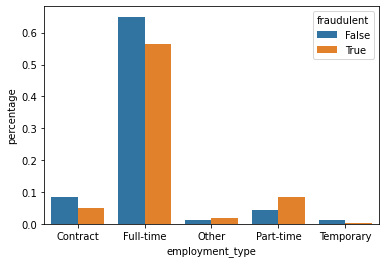

In [ ]:
plotComparingColumn(df_fraud, df_job_descriptions, 'employment_type')

###**required_experience**

There are 7 unique required experience values

In [ ]:
df_job_descriptions['required_experience'].unique()

array(['Internship', 'Not Applicable', nan, 'Mid-Senior level',
       'Associate', 'Entry level', 'Executive', 'Director'], dtype=object)

In [ ]:
required_experience_dict = {}
createDictionary(df_job_descriptions, 'required_experience', required_experience_dict)

In [ ]:
df_job_descriptions['required_experience_number'] = df_job_descriptions['required_experience'].map(required_experience_dict)

Over 20% of fraudulent jobs are entry level, next is mid-senior level. The fraudulent jobs appear to decrease in percentage as the experience required increases. 

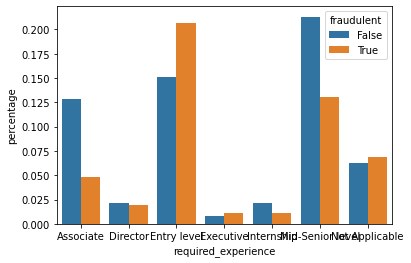

In [ ]:
plotComparingColumn(df_fraud, df_job_descriptions, 'required_experience')

###**required_education**

There are 13 unique required education values

In [ ]:
df_job_descriptions['required_education'].nunique()

13

In [ ]:
df_job_descriptions['required_education'].unique()

array([nan, "Bachelor's Degree", "Master's Degree",
       'High School or equivalent', 'Unspecified',
       'Some College Coursework Completed', 'Vocational', 'Certification',
       'Associate Degree', 'Professional', 'Doctorate',
       'Some High School Coursework', 'Vocational - Degree',
       'Vocational - HS Diploma'], dtype=object)

In [ ]:
education_dict = {}
createDictionary(df_job_descriptions, 'required_education', education_dict)

In [ ]:
df_job_descriptions['required_education_number'] = df_job_descriptions['required_education'].map(education_dict)

A little under 20% of fraudulent jobs require High School education, the next highest is over 10% of fraudulent jobs requiering a Bachelor's Degree

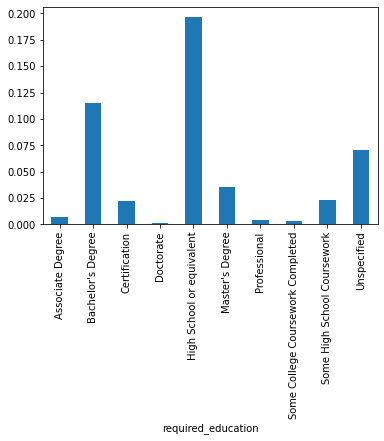

In [ ]:
barChart('required_education', df_fraud)

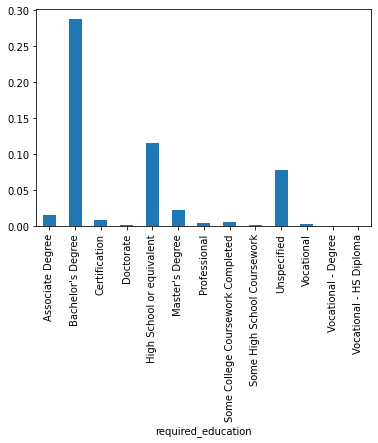

In [ ]:
barChart('required_education', df_job_descriptions)

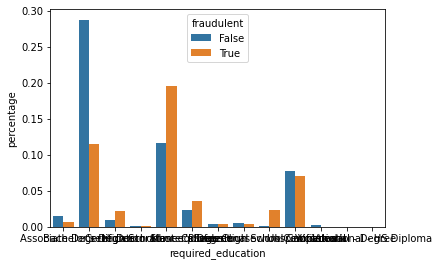

In [ ]:
plotComparingColumn(df_fraud, df_job_descriptions, 'required_education')

###**industry**

There are 131 unique industries for fraudulent jobs 

In [ ]:
df_job_descriptions['industry'].nunique()

131

In [ ]:
industry_dict = {}
createDictionary(df_job_descriptions, 'industry', required_experience_dict)

In [ ]:
df_job_descriptions['industry_number'] = df_job_descriptions['industry'].map(industry_dict)

12% of fraudulent jobs are in the Oil and Energy Industry

In [ ]:
column_type_count = df_fraud.groupby('industry')['industry'].count().sort_values(ascending=False)
column_type_count.head(10)

industry
Oil & Energy                           109
Accounting                              57
Hospital & Health Care                  51
Marketing and Advertising               45
Financial Services                      35
Information Technology and Services     32
Telecommunications                      26
Consumer Services                       24
Real Estate                             24
Leisure, Travel & Tourism               21
Name: industry, dtype: int64

In [ ]:
percent = 109/len(df_fraud)
print(percent)

0.1258660508083141


While we see only 1.6% of all jobs are in the Oil & Energy industry! Thus we see 38% of Oil & Energy jobs are fraudulent. 

In [ ]:
column_type_count = df_job_descriptions.groupby('industry')['industry'].count().sort_values(ascending=False)
column_type_count.head(10)

industry
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Financial Services                      779
Hospital & Health Care                  497
Consumer Services                       358
Telecommunications                      342
Oil & Energy                            287
Name: industry, dtype: int64

In [ ]:
percent =  287/len(df_job_descriptions)
print(percent)

0.016051454138702462


###**function**

There are 37 unique functions however fraudulent jobs are only in 27 of those functions

In [ ]:
df_job_descriptions['function'].nunique()

37

In [ ]:
df_fraud['function'].nunique()

27

In [ ]:
function_dict = {}
createDictionary(df_job_descriptions, 'function', function_dict)

In [ ]:
df_job_descriptions['function_number'] = df_job_descriptions['function'].map(function_dict)

Fraudulent jobs appear most in Administrative and Engineering functions

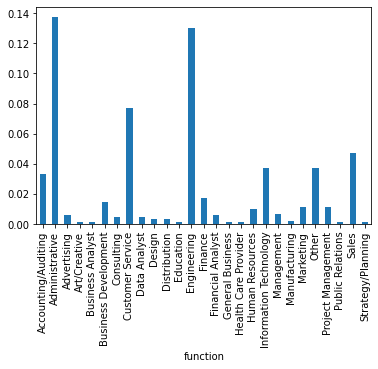

In [ ]:
barChart('function', df_fraud)

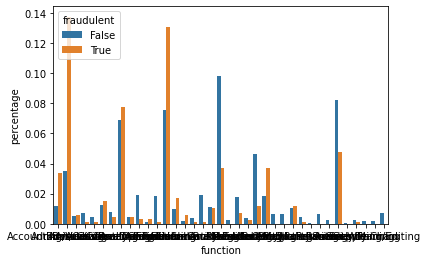

In [ ]:
plotComparingColumn(df_fraud, df_job_descriptions, 'function')

### **telecommuting**

Only 4.29% of jobs are telecommuting jobs, or work from home

In [ ]:
df_job_descriptions['telecommuting'].value_counts(normalize=True)

0    0.957103
1    0.042897
Name: telecommuting, dtype: float64

In [ ]:
df_telecommut = df_job_descriptions[df_job_descriptions['telecommuting']==1]
df_no_telecommut = df_job_descriptions[df_job_descriptions['telecommuting']==0]

91.65% of the jobs that telecommute are real, and 8.24% are fraudulent

In [ ]:
df_telecommut['fraudulent'].value_counts(normalize=True)

0    0.916558
1    0.083442
Name: fraudulent, dtype: float64

95% of the jobs that do not telecommute are real jobs  

In [ ]:
df_no_telecommut['fraudulent'].value_counts(normalize=True)

0    0.953135
1    0.046865
Name: fraudulent, dtype: float64

###**has_company_logo**

79.53% of job postings include a company logo

In [ ]:
df_job_descriptions['has_company_logo'].value_counts(normalize=True)

1    0.795302
0    0.204698
Name: has_company_logo, dtype: float64

In [ ]:
df_logo = df_job_descriptions[df_job_descriptions['has_company_logo']==1]
df_no_logo = df_job_descriptions[df_job_descriptions['has_company_logo']==0]

98% of the jobs that contain a company logo are real jobs

In [ ]:
df_logo['fraudulent'].value_counts(normalize=True)

0    0.980098
1    0.019902
Name: fraudulent, dtype: float64

84% of the jobs that do not containa company logo are real jobs 

In [ ]:
df_no_logo['fraudulent'].value_counts(normalize=True)

0    0.84071
1    0.15929
Name: fraudulent, dtype: float64

###**has_questions**

49%  of job postings include questions

In [ ]:
df_job_descriptions['has_questions'].value_counts(normalize=True)

0    0.508277
1    0.491723
Name: has_questions, dtype: float64

97% of the jobs that included questions were real jobs 

In [ ]:
df_questions = df_job_descriptions[df_job_descriptions['has_questions']==1]
df_questions['fraudulent'].value_counts(normalize=True)

0    0.971565
1    0.028435
Name: fraudulent, dtype: float64

###**missing_data_count**

The average number of items missing from a job post is 3.9

In [ ]:
df_job_descriptions['missing_data_count'].describe()

count    17880.000000
mean         3.920749
std          2.551782
min          0.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         11.000000
Name: missing_data_count, dtype: float64

### Correlation Matrix

Now that we have investegated each column and created new columns with dictionary values we can look at the correlation and compare R values.

In [ ]:
df_job_descriptions.corr()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,missing_data_count,employment_type_number,required_experience_number,required_education_number,industry_number,function_number
job_id,1.000000,-0.004559,-0.014539,-0.087025,0.079872,0.008455,-0.050987,-0.025486,-0.013506,NaN,-0.013135
telecommuting,-0.004559,1.000000,-0.019836,0.020345,0.034523,-0.052161,0.044572,0.027700,0.079819,NaN,0.010108
has_company_logo,-0.014539,-0.019836,1.000000,0.233932,-0.261971,-0.327023,0.007854,0.108863,0.064600,NaN,0.075101
has_questions,-0.087025,0.020345,0.233932,1.000000,-0.091627,-0.200894,0.081947,-0.007603,0.058803,NaN,0.095646
fraudulent,0.079872,0.034523,-0.261971,-0.091627,1.000000,0.065610,0.002962,-0.009326,0.034296,NaN,0.003221
missing_data_count,0.008455,-0.052161,-0.327023,-0.200894,0.065610,1.000000,0.203468,-0.445375,-0.471431,NaN,-0.337022
employment_type_number,-0.050987,0.044572,0.007854,0.081947,0.002962,0.203468,1.000000,-0.159062,-0.047874,NaN,-0.071670
required_experience_number,-0.025486,0.027700,0.108863,-0.007603,-0.009326,-0.445375,-0.159062,1.000000,0.240896,NaN,0.139464
required_education_number,-0.013506,0.079819,0.064600,0.058803,0.034296,-0.471431,-0.047874,0.240896,1.000000,NaN,0.133825
industry_number,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see high values of R corresponding to `has_company_logo` 0.261971. One of the next highest values is `missing_data_count` at 0.065610. However, it has a lower value than `job_id`, where we would expect this column to have no correlation to fraudulent. We suspect this is because the data was imbalanced with fraudulent postings at the end of the data set with larger `job_id` values.  And out of the columns we created with our dictionary values we see `required_education_number` has the highest correlation with 0.034296. 

In [ ]:
df_fraud = df_job_descriptions[df_job_descriptions["fraudulent"]==1]
df_real = df_job_descriptions[df_job_descriptions["fraudulent"]==0]

In [ ]:
df_fraud['job_id'].mean()

10767.83140877598

In [ ]:
df_real['job_id'].mean()

8847.490184553897

#Cleaning Data

In [ ]:
df = df_job_descriptions

Fill-in missing data

In [ ]:
for col in df.columns:
    if(df[col].dtypes == object):
      df[col] = df[col].fillna(' ')

Condense text into one column

In [ ]:
df["text"] = df["title"] + " " + df["department"] + " "  + df["company_profile"]  + " " + df["description"] + " " + df["requirements"] + " " + df["benefits"]

Create column storing character count of text

In [ ]:
df["char_count"] = df["text"].str.len()

In [ ]:
df.head(1)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,char_count
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern Marketing We're Food52, and w...",2673


Drop columns we no longer need in our analysis

In [ ]:
df = df.drop(['job_id', 'title', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits'], axis='columns')

#Save Clean Data and training/test/vailidation to CSV 

Since we used independent notebooks for exploration we found it helpful to save our cleaned data. That way we can all use the same data sets in our exploration.

In [ ]:
df.to_csv(drive_dir + 'descriptions_cleaned.csv', index=False)
df_cleaned = pd.read_csv(drive_dir + 'descriptions_cleaned.csv')
df_cleaned.head()

,location,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,char_count
0,"US, NY, New York",0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern Marketing We're Food52, and w...",2673
1,"NZ, , Auckland",0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production Succ...,6141
2,"US, IA, Wever",0,1,0,,,,,,0,Commissioning Machinery Assistant (CMA) Valo...,2643
3,"US, DC, Washington",0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Account Executive - Washington DC Sales Our pa...,5468
4,"US, FL, Fort Worth",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC...,3951


In [ ]:
from sklearn.model_selection import train_test_split

Split data into testing, training and validation sets, we used `stratify=df_cleaned['fraudulent']` to keep the ratio of fraudulent jobs to non-fraudulent jobs the same. 

In [ ]:
train_df, test_df = train_test_split(df_cleaned, test_size=0.3, stratify=df_cleaned['fraudulent'])

In [ ]:
# Use 10% of the original data as the validation data
train_df, valid_df = train_test_split(train_df, test_size=int(0.1*df.shape[0]), stratify=train_df['fraudulent'])

In [ ]:
print(f'Rows in original data: {df.shape[0]}')
print(f'Rows in training data: {train_df.shape[0]} ({100*train_df.shape[0] / df.shape[0]:.2f}%)')
print(f'Rows in validation data: {valid_df.shape[0]} ({100*valid_df.shape[0] / df.shape[0]:.2f}%)')
print(f'Rows in testing data: {test_df.shape[0]} ({100*test_df.shape[0] / df.shape[0]:.2f}%)')

assert df.shape[0] == train_df.shape[0] + valid_df.shape[0] + test_df.shape[0], "Data sizes don't match"

Rows in original data: 17880
Rows in training data: 10728 (60.00%)
Rows in validation data: 1788 (10.00%)
Rows in testing data: 5364 (30.00%)


In [ ]:
train_df.to_csv(drive_dir + 'train.csv', index=False)
valid_df.to_csv(drive_dir + 'valid.csv', index=False)
test_df.to_csv(drive_dir + 'test.csv', index=False)

#Initial Text Analysis Looking at Charcacter Counts 

In [ ]:
def charPlot(df, fradCol, tectCol):
  fig,(ax1,ax2)= plt.subplots(ncols=1, figsize=(17, 5), dpi=100, sharex=True, nrows=2)
  length=df[df[fradCol]==1][tectCol].str.len()
  ax1.hist(length,bins = 20,color='orangered')
  ax1.set_title('Fake Post')
  length=df[df[fradCol]==0][tectCol].str.len()
  ax2.hist(length, bins = 20)
  ax2.set_title('Real Post')
  fig.suptitle(f'Characters in {tectCol} column')
  plt.show()

Looking at the histogram we can see the graph for real posts is shifted right compared to fake posts. This shows us there is a measurable difference in the length of real jobs vs fake jobs text. 

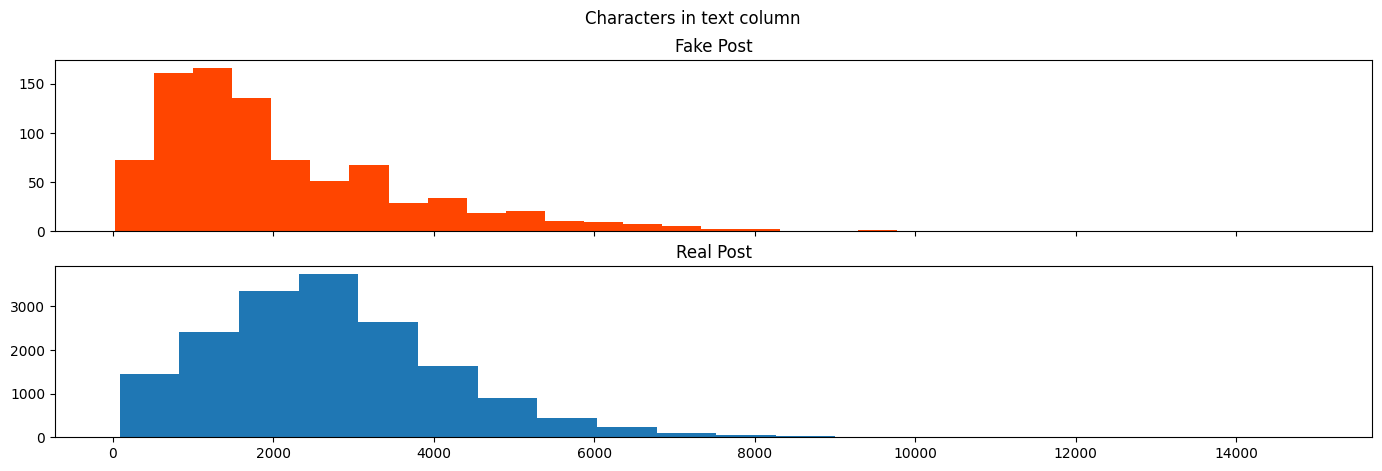

In [ ]:
charPlot(df_cleaned, 'fraudulent', 'text')

Compare the mean number of characters from all text in Fraudulent vs Non-Fraudulent Job Postings 

In [ ]:
df_fraudulent = df[df["fraudulent"]==1]

In [ ]:
df_fraudulent['char_count'].describe()

count     866.000000
mean     2086.587760
std      1531.485003
min        24.000000
25%       954.500000
50%      1662.500000
75%      2888.500000
max      9772.000000
Name: char_count, dtype: float64

In [ ]:
df_real = df[df["fraudulent"]==0]

In [ ]:
df_real['char_count'].describe()

count    17014.000000
mean      2706.626954
std       1456.538314
min         88.000000
25%       1643.000000
50%       2569.000000
75%       3505.000000
max      14950.000000
Name: char_count, dtype: float64

Job posting that are fraudulent on average have 23% less characters

In [ ]:
percentDiff = (1- (df_fraudulent['char_count'].mean()/df_real['char_count'].mean()))
print(percentDiff)

0.22908188122447137


# Text Analysis

In our text anaysis we work with TF-IDF Term Frequency – Inverse Document - Term Frequency: This summarizes how often a given word appears within a document.
-Inverse Document Frequency: This downscales words that appear a lot across documents.

The TfidfVectorizer will tokenize documents, learn the vocabulary and inverse document frequency weightings, and allow you to encode new documents. 

Once we determine which terms appear in fraudulent vs non-fraudulent job postings we will flag the appearance of these words and use this data frame to predict fraudulent job postings. 

First step is to stem and split words

In [ ]:
from nltk.stem.snowball import SnowballStemmer
from nltk.util import ngrams
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stemmer = SnowballStemmer('english')
stops = set(stopwords.words('english'))

In [ ]:
df_job_descriptions['text_lower'] = df_job_descriptions['text'].str.lower()
df_job_descriptions['text_lower'].head()

0    marketing intern marketing we're food52, and w...
1    customer service - cloud video production succ...
2    commissioning machinery assistant (cma)   valo...
3    account executive - washington dc sales our pa...
4    bill review manager   spotsource solutions llc...
Name: text_lower, dtype: object

In [ ]:
df_job_descriptions['text_lower'] = df_job_descriptions['text_lower'].str.replace('[^\w\s]','')
df_job_descriptions['text_lower'].head()

0    marketing intern marketing were food52 and wev...
1    customer service  cloud video production succe...
2    commissioning machinery assistant cma   valor ...
3    account executive  washington dc sales our pas...
4    bill review manager   spotsource solutions llc...
Name: text_lower, dtype: object

In [ ]:
df_job_descriptions['text_stopwords'] = df_job_descriptions['text_lower'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

In [ ]:
df_job_descriptions['text_split'] = df_job_descriptions['text_stopwords'].str.split()

In [ ]:
df_job_descriptions['text_split_stem'] = df_job_descriptions['text_split'].apply(lambda x: [stemmer.stem(y) for y in x])
df_job_descriptions.drop(columns= ["text_split"])

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,text,char_count,text_lower,text_stopwords,text_split_stem
0,1,Marketing Intern,"US, NY, New York",Marketing,,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,,,Marketing,0,"Marketing Intern Marketing We're Food52, and w...",2673,marketing intern marketing were food52 and wev...,marketing intern marketing food52 weve created...,"[market, intern, market, food52, weve, creat, ..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production Succ...,6141,customer service cloud video production succe...,customer service cloud video production succes...,"[custom, servic, cloud, video, product, succes..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,,,,,,0,Commissioning Machinery Assistant (CMA) Valo...,2643,commissioning machinery assistant cma valor ...,commissioning machinery assistant cma valor se...,"[commiss, machineri, assist, cma, valor, servi..."
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Account Executive - Washington DC Sales Our pa...,5468,account executive washington dc sales our pas...,account executive washington dc sales passion ...,"[account, execut, washington, dc, sale, passio..."
4,5,Bill Review Manager,"US, FL, Fort Worth",,,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bill Review Manager SpotSource Solutions LLC...,3951,bill review manager spotsource solutions llc...,bill review manager spotsource solutions llc g...,"[bill, review, manag, spotsourc, solut, llc, g..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,,Computer Software,Sales,0,Account Director - Distribution Sales Vend is...,5322,account director distribution sales vend is ...,account director distribution sales vend looki...,"[account, director, distribut, sale, vend, loo..."
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,Payroll Accountant Accounting WebLinc is the e...,4751,payroll accountant accounting weblinc is the e...,payroll accountant accounting weblinc ecommerc...,"[payrol, account, account, weblinc, ecommerc, ..."
17877,17878,Project Co

In [ ]:
df_fraudulent = df_job_descriptions[df_job_descriptions['fraudulent'] == 1]
df_real = df_job_descriptions[df_job_descriptions['fraudulent'] == 0]

In [ ]:
df_real = df_real.drop(columns = ['text_stopwords','text_split'])
df_fraudulent = df_fraudulent.drop(columns= ['text_stopwords','text_split'])

In [ ]:
df_fraudulent['text_stem'] = df_fraudulent['text'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))
df_real['text_stem'] = df_real['text'].apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
vector = TfidfVectorizer
cvector = CountVectorizer(stop_words='english', min_df=1, max_df=.5, ngram_range=(1,1))
trans = TfidfTransformer()

##For fraudulent job postings

The vocabulary of fraudulent postings and the number of times that word appears

In [ ]:
from itertools import islice
cvector.fit(df_fraudulent.text_stem)
list(islice(cvector.vocabulary_.items(), 20))

[('ic', 4298),
 ('technician', 8776),
 ('oil', 5965),
 ('energi', 3073),
 ('staf', 8334),
 ('amp', 634),
 ('recruit', 7223),
 ('right', 7602),
 ('industry', 4452),
 ('repres', 7375),
 ('candid', 1410),
 ('automat', 997),
 ('grant', 3962),
 ('follow', 3675),
 ('perks', 6356),
 ('expert', 3424),
 ('negoti', 5761),
 ('behalf', 1116),
 ('maxim', 5347),
 ('compens', 1859)]

In [ ]:
len(cvector.vocabulary_)

9953

In [ ]:
cvector_counts_fraudulent = cvector.transform(df_fraudulent.text_stem)
print('sparse matrix shape:', cvector_counts_fraudulent.shape)

sparse matrix shape: (866, 9953)


The number of texts in which each word appears

In [ ]:
occ = np.asarray(cvector_counts_fraudulent.sum(axis=0)).ravel().tolist()
counts_df_fraudulent = pd.DataFrame({'term': cvector.get_feature_names(), 'occurrences': occ})
counts_df_fraudulent = counts_df_fraudulent.sort_values(by='occurrences', ascending=False)
counts_df_fraudulent.head()

,term,occurrences
5214,manag,1282
634,amp,1154
2252,custom,1006
6837,product,1006
8749,team,931


Finding the weight of each word, or the frequency each word has per document

In [ ]:
fraudulent_weights = trans.fit_transform(cvector_counts_fraudulent)

In [ ]:
fraudulent_weights_array = np.asarray(fraudulent_weights.mean(axis=0)).ravel().tolist()
fraudulent_weights_df = pd.DataFrame({'term': cvector.get_feature_names(), 'fraud_weight': fraudulent_weights_array}).sort_values(by='fraud_weight', ascending=False)
fraudulent_weights_df.head(10)

,term,fraud_weight
2252,custom,0.035062
634,amp,0.033780
5214,manag,0.032641
2297,data,0.030998
6611,posit,0.030517
8949,time,0.027689
6837,product,0.026253
4190,home,0.025727
8370,start,0.025085
2565,develop,0.024495


##For real job postings

The vocabulary of real postings and the number of texts that contains each word

In [ ]:
cvector.fit(df_real.text_stem)
list(islice(cvector.vocabulary_.items(), 20))

[('market', 48633),
 ('intern', 41803),
 ('food52', 33409),
 ('creat', 19170),
 ('groundbreak', 36236),
 ('award', 8499),
 ('win', 92352),
 ('cook', 18460),
 ('site', 75558),
 ('support', 80786),
 ('connect', 17630),
 ('celebr', 13459),
 ('home', 38034),
 ('cooks', 18473),
 ('everyth', 30013),
 ('need', 52890),
 ('place', 59995),
 ('editorial', 26236),
 ('business', 11855),
 ('engin', 27803)]

In [ ]:
len(cvector.vocabulary_)

97328

In [ ]:
cvector_counts_real = cvector.transform(df_real.text_stem)
print('sparse matrix shape:', cvector_counts_real.shape)

sparse matrix shape: (17014, 97328)


The number of texts in which each word appears

In [ ]:
occ = np.asarray(cvector_counts_real.sum(axis=0)).ravel().tolist()
counts_df_real = pd.DataFrame({'term': cvector.get_feature_names(), 'occurrences': occ})
counts_df_real = counts_df_real.sort_values(by='occurrences', ascending=False)
counts_df_real.head()

,term,occurrences
19960,custom,24767
63873,product,22575
74213,servic,21808
11851,busi,20726
14884,client,17902


Finding the weight of each word, or the frequency each word has per document

In [ ]:
real_weights = trans.fit_transform(cvector_counts_real)

In [ ]:
real_weights_array = np.asarray(real_weights.mean(axis=0)).ravel().tolist()
real_weights_df = pd.DataFrame({'term': cvector.get_feature_names(), 'real_weight': real_weights_array}).sort_values(by='real_weight', ascending=False)
real_weights_df.head(10)

,term,real_weight
19960,custom,0.030559
63873,product,0.025534
43333,job,0.025393
74213,servic,0.024631
72264,sale,0.024603
11851,busi,0.023878
22405,design,0.023614
14884,client,0.022724
48633,market,0.022697
4897,amp,0.020781


##Fraudulent and Real terms and weights

In [ ]:
real_weights_df.shape

(97328, 2)

In [ ]:
fraudulent_weights_df.shape

(9953, 2)

Joining the real and fraudulent term weights by the term

In [ ]:
joined_weights_df = pd.merge(real_weights_df, fraudulent_weights_df, how='outer', on='term')
joined_weights_df.head(10)

,term,real_weight,fraud_weight
0,custom,0.030559,0.035062
1,product,0.025534,0.026253
2,job,0.025393,0.023186
3,servic,0.024631,NaN
4,sale,0.024603,0.021084
5,busi,0.023878,0.020273
6,design,0.023614,0.016337
7,client,0.022724,0.015147
8,market,0.022697,0.012457
9,amp,0.020781,0.033780


In [ ]:
joined_weights_df.shape

(100030, 3)

Finding which terms have no real weight or fraudulent weight

In [ ]:
joined_weights_df[joined_weights_df['real_weight'].isna()].head()

,term,real_weight,fraud_weight
97328,manag,NaN,0.032641
97329,time,NaN,0.027689
97330,develop,NaN,0.024495
97331,team,NaN,0.024152
97332,year,NaN,0.019852


In [ ]:
joined_weights_df[joined_weights_df['fraud_weight'].isna()].head()

,term,real_weight,fraud_weight
3,servic,0.024631,NaN
24,skill,0.014454,NaN
218,asia,0.006476,NaN
222,living,0.006433,NaN
226,tefl,0.006356,NaN


Calculating the average weight for each term

In [ ]:
joined_weights_df['weight_average'] = joined_weights_df.median(axis=1, skipna=False)
joined_weights_df.head(10)

,term,real_weight,fraud_weight,weight_average
0,custom,0.030559,0.035062,0.032810
1,product,0.025534,0.026253,0.025894
2,job,0.025393,0.023186,0.024289
3,servic,0.024631,NaN,NaN
4,sale,0.024603,0.021084,0.022843
5,busi,0.023878,0.020273,0.022076
6,design,0.023614,0.016337,0.019975
7,client,0.022724,0.015147,0.018935
8,market,0.022697,0.012457,0.017577
9,amp,0.020781,0.033780,0.027280


In [ ]:
joined_weights_df.nlargest(10,'real_weight')

,term,real_weight,fraud_weight,weight_average
0,custom,0.030559,0.035062,0.032810
1,product,0.025534,0.026253,0.025894
2,job,0.025393,0.023186,0.024289
3,servic,0.024631,NaN,NaN
4,sale,0.024603,0.021084,0.022843
5,busi,0.023878,0.020273,0.022076
6,design,0.023614,0.016337,0.019975
7,client,0.022724,0.015147,0.018935
8,market,0.022697,0.012457,0.017577
9,amp,0.020781,0.033780,0.027280


In [ ]:
real_terms = joined_weights_df.nlargest(10,'real_weight')['term'].to_list()
real_terms

['custom',
 'product',
 'job',
 'servic',
 'sale',
 'busi',
 'design',
 'client',
 'market',
 'amp']

In [ ]:
joined_weights_df.nlargest(10,'fraud_weight')

,term,real_weight,fraud_weight,weight_average
0,custom,0.030559,0.035062,0.032810
9,amp,0.020781,0.033780,0.027280
97328,manag,NaN,0.032641,NaN
15,data,0.016568,0.030998,0.023783
28,posit,0.014186,0.030517,0.022352
97329,time,NaN,0.027689,NaN
1,product,0.025534,0.026253,0.025894
78,home,0.011015,0.025727,0.018371
94,start,0.010316,0.025085,0.017700
97330,develop,NaN,0.024495,NaN


In [ ]:
fraud_terms = joined_weights_df.nlargest(10,'fraud_weight')['term'].to_list()
fraud_terms

['custom',
 'amp',
 'manag',
 'data',
 'posit',
 'time',
 'product',
 'home',
 'start',
 'develop']

##Create Word Clouds to visulize common words 

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

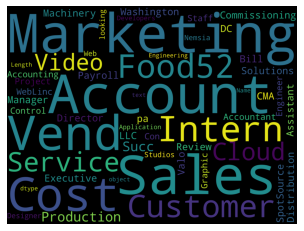

In [ ]:
text = df_real['text']
wordcloud = WordCloud(width = 4000,height = 3000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

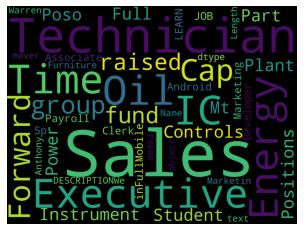

In [ ]:
text = df_fraudulent['text']
wordcloud = WordCloud(width = 4000,height = 3000, background_color = 'black', stopwords = STOPWORDS).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

##TF-IDF to determine important words

Creating a 'text exclusive' dataframe with an added column

In [ ]:
df_job_descriptions_text = df_job_descriptions[['fraudulent', 'text',	'text_lower',	'text_stopwords',	'text_split',	'text_split_stem']]
df_job_descriptions_text

,fraudulent,text,text_lower,text_stopwords,text_split,text_split_stem
0,0,"Marketing Intern Marketing We're Food52, and w...",marketing intern marketing were food52 and wev...,marketing intern marketing food52 weve created...,"[marketing, intern, marketing, food52, weve, c...","[market, intern, market, food52, weve, creat, ..."
1,0,Customer Service - Cloud Video Production Succ...,customer service cloud video production succe...,customer service cloud video production succes...,"[customer, service, cloud, video, production, ...","[custom, servic, cloud, video, product, succes..."
2,0,Commissioning Machinery Assistant (CMA) Valo...,commissioning machinery assistant cma valor ...,commissioning machinery assistant cma valor se...,"[commissioning, machinery, assistant, cma, val...","[commiss, machineri, assist, cma, valor, servi..."
3,0,Account Executive - Washington DC Sales Our pa...,account executive washington dc sales our pas...,account executive washington dc sales passion ...,"[account, executive, washington, dc, sales, pa...","[account, execut, washington, dc, sale, passio..."
4,0,Bill Review Manager SpotSource Solutions LLC...,bill review manager spotsource solutions llc...,bill review manager spotsource solutions llc g...,"[bill, review, manager, spotsource, solutions,...","[bill, review, manag, spotsourc, solut, llc, g..."
...,...,...,...,...,...,...
17875,0,Account Director - Distribution Sales Vend is...,account director distribution sales vend is ...,account director distribution sales vend looki...,"[account, director, distribution, sales, vend,...","[account, director, distribut, sale, vend, loo..."
17876,0,Payroll Accountant Accounting WebLinc is the e...,payroll accountant accounting weblinc is the e...,payroll accountant accounting weblinc ecommerc...,"[payroll, accountant, accounting, weblinc, eco...","[payrol, account, account, weblinc, ecommerc, ..."
17877,0,Project Cost Control Staff Engineer - Cost Con...,project cost control staff engineer cost cont...,project cost control staff engineer cost contr...,"[project, cost, control, staff, engineer, cost...","[project, cost, control, staff, engin, cost, c..."
17878,0,Graphic Designer Nemsia Studios is looking...,graphic designer nemsia studios is looking...,graphic designer nemsia studios looking experi...,"[graphic, designer, nemsia, studios, looking, ...","[graphic, design, nemsia, studio, look, experi..."


In [ ]:
df_job_descriptions_text['text_stem'] = [' '.join(map(str, l)) for l in df_job_descriptions_text['text_split_stem']]
df_job_descriptions_text['text_stem']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        market intern market food52 weve creat groundb...
1        custom servic cloud video product success 90 s...
2        commiss machineri assist cma valor servic prov...
3        account execut washington dc sale passion impr...
4        bill review manag spotsourc solut llc global h...
                               ...                        
17875    account director distribut sale vend look awes...
17876    payrol account account weblinc ecommerc platfo...
17877    project cost control staff engin cost control ...
17878    graphic design nemsia studio look experienc vi...
17879    web applic develop engin vend look awesom new ...
Name: text_stem, Length: 17880, dtype: object

Adding columns of the most used word stems of real and fraudulent postings, and stating whether it has the term in the text

In [ ]:
def termColumn(df_job_descriptions_text, termList):
  for term in termList:
    df_job_descriptions_text[term] = df_job_descriptions_text['text_stem'].str.contains(term).astype(bool)

In [ ]:
termColumn(df_job_descriptions_text, real_terms)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
termColumn(df_job_descriptions_text, fraud_terms)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


The new dataframe with 17 added 'term' columns

In [ ]:
df_job_descriptions_text.head()

,fraudulent,text,text_lower,text_stopwords,text_split,text_split_stem,text_stem,custom,product,job,servic,sale,busi,design,client,market,amp,manag,data,posit,time,home,start,develop
0,0,"Marketing Intern Marketing We're Food52, and w...",marketing intern marketing were food52 and wev...,marketing intern marketing food52 weve created...,"[marketing, intern, marketing, food52, weve, c...","[market, intern, market, food52, weve, creat, ...",market intern market food52 weve creat groundb...,False,False,False,False,False,True,False,False,True,True,True,False,False,True,True,True,True
1,0,Customer Service - Cloud Video Production Succ...,customer service cloud video production succe...,customer service cloud video production succes...,"[customer, service, cloud, video, production, ...","[custom, servic, cloud, video, product, succes...",custom servic cloud video product success 90 s...,True,True,False,True,False,True,False,True,False,True,True,False,True,True,False,True,False
2,0,Commissioning Machinery Assistant (CMA) Valo...,commissioning machinery assistant cma valor ...,commissioning machinery assistant cma valor se...,"[commissioning, machinery, assistant, cma, val...","[commiss, machineri, assist, cma, valor, servi...",commiss machineri assist cma valor servic prov...,False,False,False,True,False,False,False,True,False,True,True,False,True,False,False,False,False
3,0,Account Executive - Washington DC Sales Our pa...,account executive washington dc sales our pas...,account executive washington dc sales passion ...,"[account, executive, washington, dc, sales, pa...","[account, execut, washington, dc, sale, passio...",account execut washington dc sale passion impr...,True,False,False,True,True,True,False,False,False,True,True,False,True,True,False,False,True
4,0,Bill Review Manager SpotSource Solutions LLC...,bill review manager spotsource solutions llc...,bill review manager spotsource solutions llc g...,"[bill, review, manager, spotsource, solutions,...","[bill, review, manag, spotsourc, solut, llc, g...",bill review manag spotsourc solut llc global h...,True,True,True,True,False,True,False,True,False,True,True,False,True,True,False,True,True


Training the model based on whether a text has certain terms

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [ ]:
train_df, test_df = train_test_split(df_job_descriptions_text, test_size=0.3)

In [ ]:
X_cols = ['custom',	'product',	'job',	'servic',	'sale',	'busi',	'design',	'client',	'market',	'amp',	'manag',	'data',	'posit',	'time',	'home',	'start',	'develop']
y_col = 'fraudulent'

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test = test_df[X_cols]
y_test = test_df[y_col]

In [ ]:
clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_pred = clf.predict(X_test)
pd.Series(test_pred).value_counts()

# K-Nearest Neighbors Model

- K—Nearest Neighbors, KNN, is one of the simplest, mostly using classification algorithm used in data mining and machine learning, it's a classifier algorithm where the learning is based “how similar” is a data (a vector) from other .

- KNN is a non-parametric learning algorithm. Its purpose is to use a database in which the data points are separated into several classes to predict the classification of a new sample point.
Non-parametric means that it does not make any assumptions on the underlying data distribution. In other words, the model structure is determined from the data.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [ ]:
df_job_descriptions = pd.read_csv(drive_dir + 'descriptions_cleaned.csv')

train_df, test_df = train_test_split(df_job_descriptions, test_size=0.3)

In [ ]:
train_df, valid_df = train_test_split(train_df, test_size=int(0.2*df_job_descriptions.shape[0]))

df_train = pd.read_csv(drive_dir + 'train.csv')
df_valid = pd.read_csv(drive_dir + 'valid.csv')
df_test = pd.read_csv(drive_dir + 'test.csv')

train_df.to_csv(drive_dir + 'train.csv', index=False)
valid_df.to_csv(drive_dir + 'valid.csv', index=False)
test_df.to_csv(drive_dir + 'test.csv', index=False)


Algorithm (Training K-Nearest Neighbor Model)

In [ ]:
# Instantiate it and set the n_neighbors hyperparameter
knn = KNeighborsClassifier(n_neighbors=6)

# Pick the columns you want the model to use to measure "similarity"
cols_to_use = ['has_company_logo','has_questions','missing_data_count']

# Select just those columns for X
# Select the column you want to predict for y
# Repeat for both the training and testing sets
X_train = train_df[cols_to_use]
y_train = train_df['fraudulent']

X_valid = valid_df[cols_to_use]
y_valid = valid_df['fraudulent']

X_test = valid_df[cols_to_use]
y_test = valid_df['fraudulent']


# Fit the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the validation data

preds = knn.predict(X_valid)
test_pred = knn.predict(X_test)

# Look at your predictions
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Accuracy Percentage (Validation Set)

In [ ]:
acc = knn.score(X_valid, y_valid)

print(f'{100*acc:.2f}% accuracy on the validation set')

94.77% accuracy on the validation set


Accuracy Graph

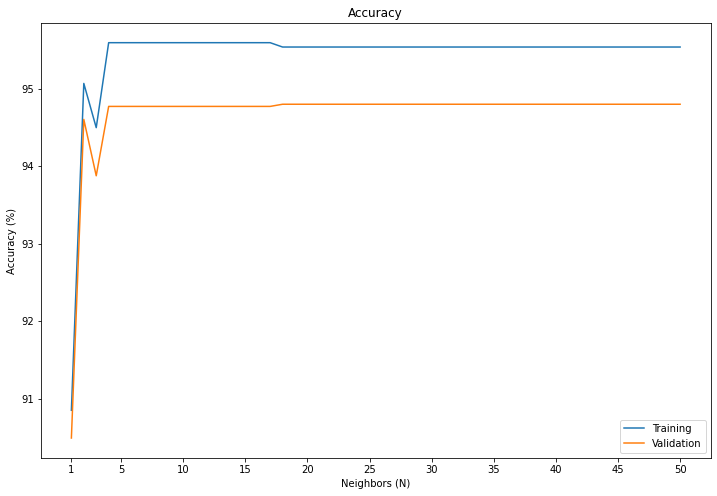

In [ ]:
train_acc_list = []
valid_acc_list = []
test_acc_list = []

cols_to_use = ['has_company_logo','has_questions','missing_data_count']
max_neighbors = 50

X_train = train_df[cols_to_use]
y_train = train_df['fraudulent']

X_valid = valid_df[cols_to_use]
y_valid = valid_df['fraudulent']

#X_test = test_df[cols_to_use]
#y_test = test_df['fraudulent']

for N in range(1, max_neighbors+1):
    knn = KNeighborsClassifier(n_neighbors=N)
    knn.fit(X_train, y_train)
    
    train_acc = knn.score(X_train, y_train)
    valid_acc = knn.score(X_valid, y_valid)
    # test_acc = knn.score(X_test, y_test)
    
    train_acc_list.append(100*train_acc)
    valid_acc_list.append(100*valid_acc)
    # test_acc_list.append(100*test_acc)
    
plt.figure(figsize=(12, 8))
plt.plot(range(1, max_neighbors+1), train_acc_list, label='Training')
plt.plot(range(1, max_neighbors+1), valid_acc_list, label='Validation')
# plt.plot(range(1, max_neighbors+1), test_acc_list, label='Test')
plt.xticks([1] + list(range(5, max_neighbors+1, 5)))
plt.xlabel('Neighbors (N)')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy');

Accuracy Percentage (Test Set)
- Accuracy is quite high already, but since the data is highly imbalanced, so no need to care what accuracy is unless it's over 99%.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

acc = knn.score(X_test, y_test)
print(f'Test set accuracy: {100*acc:.2f}%')

Test set accuracy: 94.77%


Classification Report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3390
           1       0.00      0.00      0.00       186

    accuracy                           0.95      3576
   macro avg       0.47      0.50      0.49      3576
weighted avg       0.90      0.95      0.92      3576



Precision Score

In [ ]:
from sklearn.metrics import precision_score

print("Precision score: {}".format(precision_score(y_test,test_pred)))

Precision score: 0.0


F-1 Score
- A measure of a model's accuracy on a dataset.(KNN model in this case)

In [ ]:
from sklearn.metrics import f1_score

print("F1 Score: {}".format(f1_score(y_test,test_pred)))

F1 Score: 0.0


Precision-Recall Curve
- Precision: the fraction of relevant instances among the retrieved instances
- Recall: the fraction of the total amount of relevant instances that were actually retrieved
- The precision-recall curve(PRC) shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.
- High scores for both show that the classifier(KNN in this case) is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

In [ ]:
from sklearn.metrics import average_precision_score


average_precision = average_precision_score(y_test, test_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.05


Text(0.5, 1.0, 'Precision-Recall curve: AP=0.05')

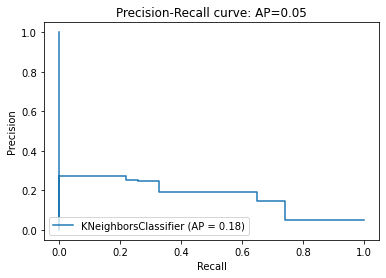

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(knn, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Logistic Regression

We are using logistic regression models as our problem is a classification problem. Where classification is the process of predicting a categorical value such as frauduent or non-fraudulent. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
clf = LogisticRegression()

The columns we can use in our analysis are 

-telecommuting	
-has_company_logo	
-has_questions		
-missing_data_count	
-char_count	
-required_education_number	
-employment_type_number	
-required_experience_number	
-industry_number	
-function_number

We preformed the logistic regression with columns of `'missing_data_count','char_count','required_education_number'` as these were the column with the strongest correlation to a job posting being fraudulent when we analyzed the correlation report. 

In [ ]:

feat_cols = ['missing_data_count', 'required_education_number' ,'employment_type_number' ,'required_experience_number','telecommuting', 'has_company_logo' ,'has_questions']
target_col = 'fraudulent'

X_train = train_df[feat_cols]
y_train = train_df[target_col]

X_test = test_df[feat_cols]
y_test = test_df[target_col]

clf.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
log_odds = clf.coef_[0]
pd.DataFrame(log_odds, 
             X_train.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=True)

,coef
has_company_logo,-2.016445
has_questions,-0.377727
employment_type_number,-0.004727
missing_data_count,0.015622
required_experience_number,0.026448
required_education_number,0.139109
telecommuting,0.259200


Check to make sure the model does predict some jobs to be fraudulent 

In [ ]:
test_pred = clf.predict(X_test)
pd.Series(test_pred).value_counts()

0    5364
dtype: int64

In [ ]:
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5083
           1       0.00      0.00      0.00       281

    accuracy                           0.95      5364
   macro avg       0.47      0.50      0.49      5364
weighted avg       0.90      0.95      0.92      5364



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Going through the classification report what is most important to us is how we preformed in predicting fraudulent jobs. 

Precision 
- Out of the jobs that were predicted to be fraudulent, what percentage of those were actually fraudulent? 0%
- Out of the jobs that were predicted to be non-fraudulent, what percentage of those were actually non-fraudulent? 95%

We can see the model has bad precision for fraudulent jobs. Even though the precision is high for non-fraudulent jobs, these values are not actually very good. Because it's the same precision we would have if we were guessing all jobs to be real.

Recall 
- Out of the jobs that were actually fraudulent, what percentage did we predict were fraudulent? 0%
- Out of the jobs that were actually non-fraudulent, what percentage did we predict were non-fraudulent? 100%

Therefore, our model is doing a very poor job at predicting fraudulent jobs.

## Model using over and under sampling

Because our data was highly imbalenced, we found it important to use this technique to see if we could give our model more oppurtunites to learn what a fraudulent job is, instead of predicting all jobs to be real with accuracy of 95.16%

95.16 is the percentage of the data that are real jobs

In [ ]:
train_df['fraudulent'].value_counts()

0    8541
1     399
Name: fraudulent, dtype: int64

In [ ]:
train_no_df = train_df[train_df['fraudulent'] == 0]
train_no_df = train_no_df.sample(3000)

train_yes_df = train_df[train_df['fraudulent'] == 1]
train_yes_df = train_yes_df.sample(1000, replace=True)

train_under_df = pd.concat([train_no_df, train_yes_df])

In [ ]:
train_under_df['fraudulent'].value_counts()

0    3000
1    1000
Name: fraudulent, dtype: int64

In [ ]:
feat_cols = ['missing_data_count', 'required_education_number' ,'employment_type_number' ,'required_experience_number','telecommuting', 'has_company_logo' ,'has_questions']
target_col = 'fraudulent'

X_train_under = train_under_df[feat_cols]
y_train_under = train_under_df[target_col]

clf_under = LogisticRegression()
clf_under.fit(X_train_under, y_train_under)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
test_pred_under = clf_under.predict(X_test)
pd.Series(test_pred_under).value_counts()

0    4786
1     578
dtype: int64

In [ ]:
print(classification_report(y_test, test_pred_under))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      5083
           1       0.16      0.33      0.22       281

    accuracy                           0.87      5364
   macro avg       0.56      0.62      0.57      5364
weighted avg       0.92      0.87      0.89      5364



The classification report shows quite different results than our previous model.

Precision is largely different for jobs that were fraudulent or non-fraudulent. For non-fraudulent jobs it prediects correct 96% of the time. This is actually an increase from the precison of 95% previously. However we can see the precision of predicting fraudulent job postings is pretty low at 16%. 

Recall 
- Out of the jobs that were actually fraudulent, what percentage did we predict were fraudulent? 33%
- Out of the jobs that were actually non-fraudulent, what percentage did we predict were non-fraudulent? 90%

This model showed a significant increase in recall, as it is much better at predicting fraudulent job postings now. 

# Summary

Overall our intial analysis led us to find fraudulent jobs appearing largely in the Oil & Enery Industry, and in Houston, TX. This is actually pretty fitting as Houston has a giant Oil & Energy sector. We also saw over 50% of fraudulent jobs as Full-Time positions, that are entry  level and only require a high school education. 

When creating models it was difficult to be good at predicting fraudulent jobs as our data set was highly imbalenced and we had limited training data. 

Looking at our results over all, we feel it would be more beneficial  to share "flags" with job seekers and to be cautious before sharing personal information. Where job seekers can still flag suspicious jobs, and when more data is acquired a better model could then be used. 